# Proyecto 4


El objetivo de este trabajo es aplicar dos modelos adicionales a los utilizados en el tercer proyecto para profundizar en el conocimiento de las herramientas aprendidas. Adicionalmente, se van a comparar los resultados con los del proyecto de Series de Tiempo y se va a concluir sobre cual es el modelo con mejor performance

Para esto, se va a repetir del tercer proyecto el análisis exploratorio de datos, la eliminación de outliers y el análisis de los componentes de la serie y su autocorrelación. 

Luego, a modo de resumen, se van a mostrar los resultados obtenidos en el proyecto anterior, y se procederá a implementar la librería Prophet y redes LSTM (Long Short-Term Memory networks). Se van a evaluar estos modelos en el conjunto de datos de testeo usando la métrica Root Mean Squared Error.

Resumiendo el tercer proyecto, se dividió el dataset en un conjunto de datos de enternamiento, que estaba conformado por el 80% de las instancias, y un set de testeo, conformado por el último 20% de los datos. Para que los resultados de los modelos en este proyecto sean comparables con los del proyecto anterior, se van a mantener estos conjuntos de datos, y se utilizará el mismo loock back de 200 lags.
Se entrenaron los siguientes modelos con estos resultados:
1. Benchmark: para predecir, copia el valor anterior de la serie.
      - RMSE (test): 5925
2. Ada boost: con hiperparámetros base_estimator=DecisionTreeRegressor(max_depth=2)learning_rate=0.1 y n_estimators=100.
      - RMSE (test): 5014
3. Gradient boosting: con los hiperparámetros learning_rate=0.01, max_depth=1 y n_estimators=500.
      - RMSE (test): 5009
4. Random forest: con hiperparámetros min_samples_leaf: 8, min_samples_split: 2 y n_estimators: 450.
      - RMSE (test): 4723.
En base a estos resultados, se había concluido que random forest era el mejor modelo.


### Librerías

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### EDA

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
data_2019 = pd.read_csv('/content/drive/MyDrive/Acamica - Data science/Proyecto 4/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/drive/MyDrive/Acamica - Data science/Proyecto 4/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/content/drive/MyDrive/Acamica - Data science/Proyecto 4/flujo-vehicular-2017.csv', sep =',')

In [6]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


In [7]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,NO COBRADO,29
1,2018,2018-01-01,0,1,Lunes,Alberdi,Centro,Liviano,TELEPASE,9
2,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,NO COBRADO,73
3,2018,2018-01-01,1,2,Lunes,Alberdi,Centro,Liviano,TELEPASE,39
4,2018,2018-01-01,2,3,Lunes,Alberdi,Centro,Liviano,NO COBRADO,115


In [8]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,NO COBRADO,25
1,2017,2017-01-01,0,1,Domingo,Alberdi,Centro,Liviano,TELEPASE,7
2,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,NO COBRADO,5
3,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,2
4,2017,2017-01-01,1,2,Domingo,Alberdi,Centro,Liviano,EFECTIVO,94


Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [9]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [10]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [11]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [12]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

In [13]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])
dataset.head()


,periodo,fecha,hora_inicio,hora_fin,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos
0,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,NO COBRADO,22
1,2019,2019-01-01,0,1,Martes,Alberti,Centro,Liviano,TELEPASE,6
2,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,NO COBRADO,53
3,2019,2019-01-01,0,1,Martes,Alberti,Provincia,Liviano,TELEPASE,18
4,2019,2019-01-01,0,1,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16


#### ¿Cuáles son las formas de pago más utilizadas?

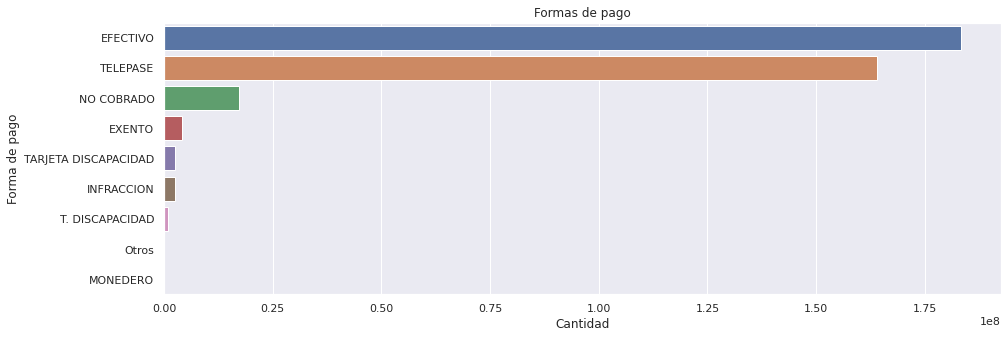

In [14]:
forma_pago = dataset.groupby(['forma_pago']).sum()['cantidad_pasos']
forma_pago = forma_pago.sort_values(ascending=False)
plt.figure(figsize=(15,5))
sns.set()
sns.barplot(y=forma_pago.index,x=forma_pago,ci='None')
plt.title("Formas de pago")
plt.xlabel("Cantidad")
plt.ylabel("Forma de pago")
plt.show()

A partir del gráfico se puede conlcuir que las formas de pago más usadas son el efectivo y el telepase. Además, se observa que hay un número importante de pasos no cobrados, siendo esta tercera en importancia.

#### ¿Cuáles son las estaciones con mayor tráfico?

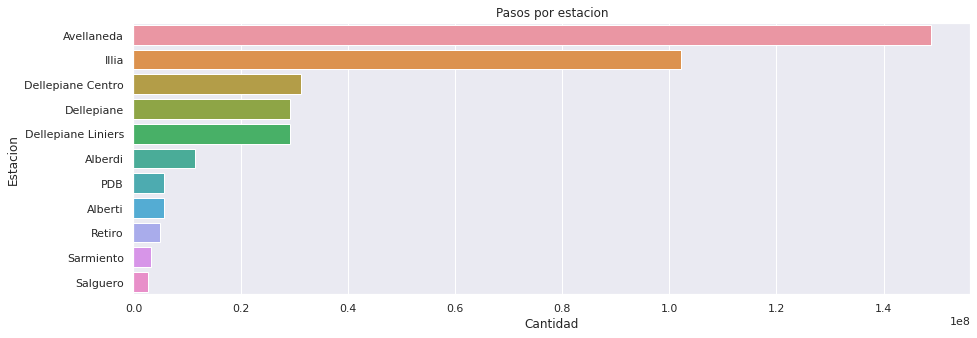

In [15]:
estacion = dataset.groupby(['estacion']).sum()['cantidad_pasos']
estacion = estacion.sort_values(ascending=False)
plt.figure(figsize=(15,5))
sns.set()
sns.barplot(y=estacion.index,x=estacion,ci='None')
plt.title("Pasos por estacion")
plt.xlabel("Cantidad")
plt.ylabel("Estacion")
plt.show()

Las estaciones con mayor cantidad de tráfico son Avellaneda, Illia y Dellepiane.

#### ¿Hacia qué sentido circulan los vehículos?

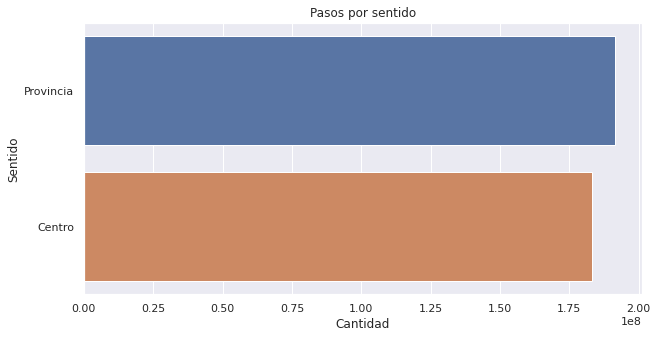

In [16]:
sentido = dataset.groupby(['sentido']).sum()['cantidad_pasos']
sentido = sentido.sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.set()
sns.barplot(y=sentido.index,x=sentido,ci='None')
plt.title("Pasos por sentido")
plt.xlabel("Cantidad")
plt.ylabel("Sentido")
plt.show()

Si bien la diferencia no es grande, hay más circulación con sentido a provincia que con sentido hacia el centro.

####  ¿Cuál es el tipo de vehículo más utilizado? ¿Cómo fue la evolución del tráfico por tipo de vehículo en los 3 años?

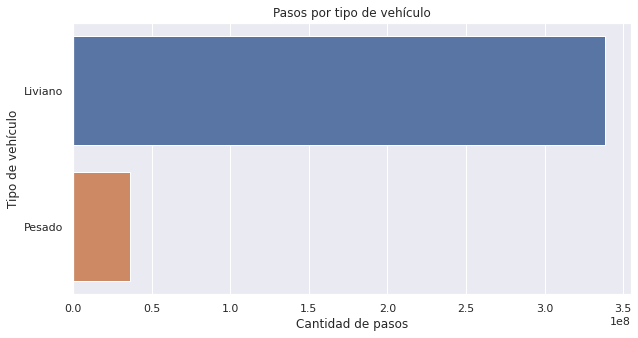

In [17]:
tipo_vehiculo = dataset.groupby(['tipo_vehiculo']).sum()['cantidad_pasos']
tipo_vehiculo = tipo_vehiculo.sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.set()
sns.barplot(y=tipo_vehiculo.index,x=tipo_vehiculo,ci='None')
plt.title("Pasos por tipo de vehículo")
plt.xlabel("Cantidad de pasos")
plt.ylabel("Tipo de vehículo")
plt.show()

Claramente, el gráfico muestra la preferencia por los vehículos livianos

In [18]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha2
0,2019,0,Martes,Alberti,Centro,Liviano,NO COBRADO,22,2019-01-01 01:00:00
1,2019,0,Martes,Alberti,Centro,Liviano,TELEPASE,6,2019-01-01 01:00:00
2,2019,0,Martes,Alberti,Provincia,Liviano,NO COBRADO,53,2019-01-01 01:00:00
3,2019,0,Martes,Alberti,Provincia,Liviano,TELEPASE,18,2019-01-01 01:00:00
4,2019,0,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16,2019-01-01 01:00:00


In [19]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,periodo,hora_inicio,dia,estacion,sentido,tipo_vehiculo,forma_pago,cantidad_pasos,fecha
0,2019,0,Martes,Alberti,Centro,Liviano,NO COBRADO,22,2019-01-01 01:00:00
1,2019,0,Martes,Alberti,Centro,Liviano,TELEPASE,6,2019-01-01 01:00:00
2,2019,0,Martes,Alberti,Provincia,Liviano,NO COBRADO,53,2019-01-01 01:00:00
3,2019,0,Martes,Alberti,Provincia,Liviano,TELEPASE,18,2019-01-01 01:00:00
4,2019,0,Martes,Avellaneda,Centro,Liviano,EFECTIVO,16,2019-01-01 01:00:00


In [20]:
data_vehiculo = pd.DataFrame(dataset.groupby([pd.Grouper(key='fecha',freq='M'),'tipo_vehiculo'])['cantidad_pasos'].sum())
data_vehiculo.reset_index(inplace=True)
data_vehiculo.head()

,fecha,tipo_vehiculo,cantidad_pasos
0,2017-01-31,Liviano,9115051
1,2017-01-31,Pesado,944247
2,2017-02-28,Liviano,8018376
3,2017-02-28,Pesado,807223
4,2017-03-31,Liviano,9298689


In [21]:
data_pesado = data_vehiculo[data_vehiculo.tipo_vehiculo=='Pesado']
data_liviano = data_vehiculo[data_vehiculo.tipo_vehiculo=='Liviano']

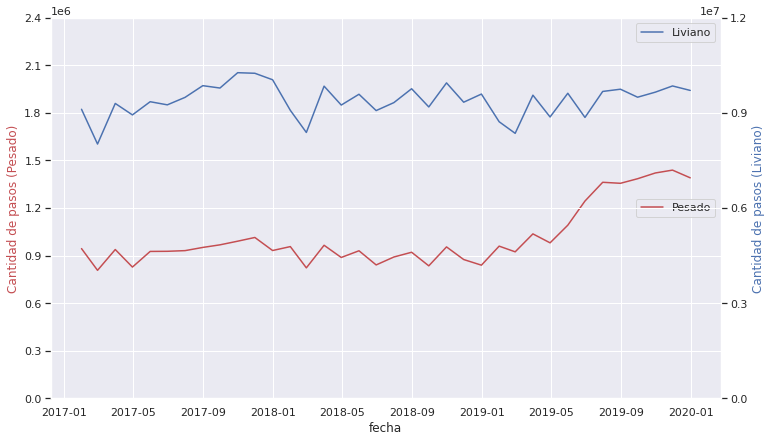

In [22]:
plt.figure(figsize=(12,7))
ax= sns.lineplot(x=data_pesado.fecha,y=data_pesado.cantidad_pasos,ci='None',label='Pesado',color='r')
ax2=ax.twinx()
ax.set_yticks(np.arange(0,2700000,300000))
ax.legend(loc='center right')
ax2= sns.lineplot(x=data_liviano.fecha,y=data_liviano.cantidad_pasos,ci='None',label='Liviano',color='b')
ax.set_ylabel('Cantidad de pasos (Pesado)', color='r')
ax2.set_ylabel('Cantidad de pasos (Liviano)', color='b')
ax2.set_yticks(np.arange(0,13000000,3000000))
ax2.legend(loc='upper right')
plt.show()

En el gráfico anterior, se observa que la conclusión que sacamos con el primer gráfico se mantiene para los 3 años considerados en el dataset. Sin embargo, se observa una tendencia alcista en el uso de vehículos pesados a partir del año 2019. Por otro lado, los vehículos livianos son los que predominan, pero el gráfico no muestra una tendencia para este tipo de vehículos.

#### ¿Las estaciones se comportan de la misma manera?

In [23]:
data_estacion = pd.DataFrame(dataset.groupby([pd.Grouper(key='fecha',freq='M'),'estacion'])['cantidad_pasos'].sum())
data_estacion.reset_index(inplace=True)

In [24]:
data_estacion = data_estacion[(data_estacion.estacion=='Alberdi') | (data_estacion.estacion=='Illia') |(data_estacion.estacion=='Avellaneda')]

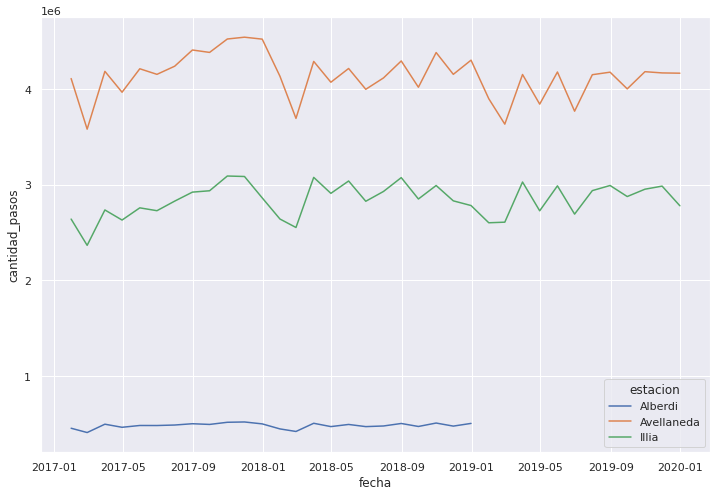

In [25]:
plt.figure(figsize=(12,8))
sns.lineplot(x=data_estacion.fecha, y=data_estacion.cantidad_pasos,hue=data_estacion.estacion)
plt.show()

Realicé una comparación de 3 estaciones (Illia, Avellaneda y Alberdi) para comparar el comportamiento entre ellas.

En el gráfico se observa que las estaciones illia y Avellaneda se comportan de forma similar, pero una más abajo de la otra ya que Avellaneda es la estación con mayor cantidad de tráfico.

Por otro lado, la estación Alberdi tiene una cantidad mucho más baja de tráfico, y solamente posee datos hasta el 2019.

#### ¿Cuáles son los horarios de mayor tráfico?

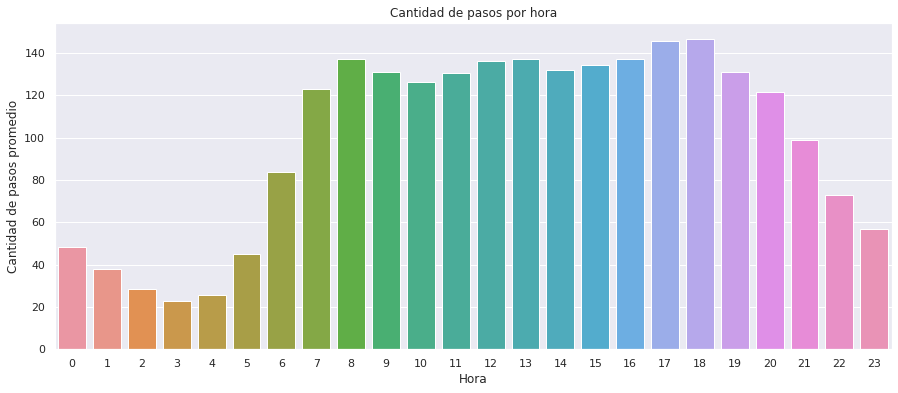

In [26]:
data_horarios_mean = dataset.groupby(by='hora_inicio')['cantidad_pasos'].mean()
plt.figure(figsize=(15,6))
sns.barplot(x=data_horarios_mean.index,y=data_horarios_mean,ci='None')
plt.title('Cantidad de pasos por hora')
plt.xlabel('Hora')
plt.ylabel('Cantidad de pasos promedio')
plt.show()

Como era de esperarse, los horarios con mayor cantidad de tráfico corresponden al horario laboral, entre las 7 de la mañana y las 8 de la noche. La mayor cantidad de tráfico se encuentra entre las 7 y 6 de las tarde, que coincide con la finalización de la jornada laboral para muchas personas.

#### Autopista Illia, medio de pago efectivo

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**

In [27]:
#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [28]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
0,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
1,Domingo,Provincia,Liviano,9,2017-01-01 00:00:00
2,Domingo,Provincia,Liviano,644,2017-01-01 00:00:00
3,Domingo,Provincia,Pesado,6,2017-01-01 00:00:00
4,Domingo,Provincia,Pesado,1,2017-01-01 00:00:00
...,...,...,...,...,...
238864,Martes,Provincia,Liviano,556,2019-12-31 22:00:00
238865,Martes,Provincia,Pesado,1,2019-12-31 22:00:00
238866,Martes,Centro,Liviano,580,2019-12-31 22:00:00
238867,Martes,Centro,Liviano,214,2019-12-31 23:00:00


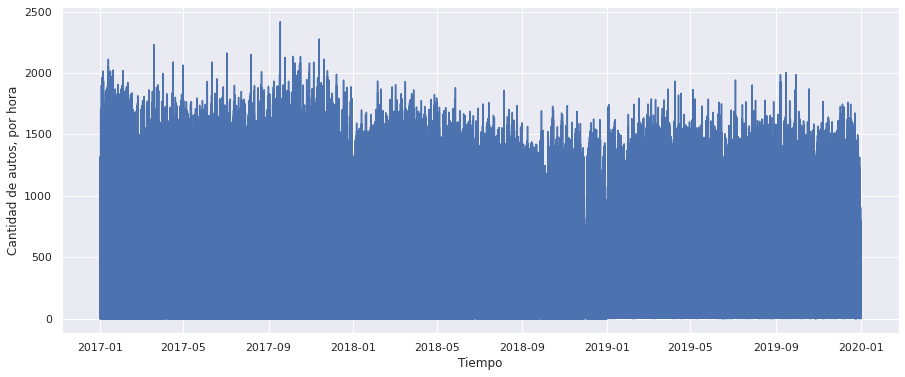

In [29]:
#Graficamos nuestros datos, tal como están
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.show()

In [30]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1095, 1)


,cantidad_pasos
fecha,
2017-01-01,31183
2017-01-02,51568
2017-01-03,51093
2017-01-04,53332
2017-01-05,56486


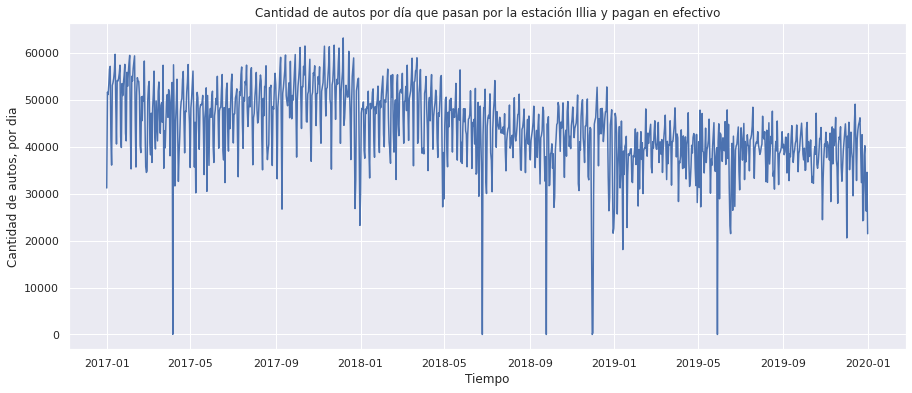

In [31]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.title('Cantidad de autos por día que pasan por la estación Illia y pagan en efectivo')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [32]:
def resample_year (dataset):
    data_year = dataset.resample('D', on='fecha').sum()
    data_year.reset_index(inplace=True)
    data_year['anio']=data_year.fecha.dt.year
    data_year['mes']=data_year.fecha.dt.month
    data_year['dia']=data_year.fecha.dt.day
    data_year['dia_semana']=data_year.fecha.dt.day_name()
    print(data_year.shape)
    return data_year

In [33]:
data_formatted = resample_year(dataset)

(1095, 6)


In [34]:
data_formatted.head()


,fecha,cantidad_pasos,anio,mes,dia,dia_semana
0,2017-01-01,31183,2017,1,1,Sunday
1,2017-01-02,51568,2017,1,2,Monday
2,2017-01-03,51093,2017,1,3,Tuesday
3,2017-01-04,53332,2017,1,4,Wednesday
4,2017-01-05,56486,2017,1,5,Thursday


In [35]:
data_formatted.describe()

,cantidad_pasos,anio,mes,dia
count,1095.000000,1095.00000,1095.000000,1095.000000
mean,43712.859361,2018.00000,6.526027,15.720548
std,8192.736927,0.81687,3.449427,8.800266
min,0.000000,2017.00000,1.000000,1.000000
25%,39061.500000,2017.00000,4.000000,8.000000
50%,43761.000000,2018.00000,7.000000,16.000000
75%,49498.000000,2019.00000,10.000000,23.000000
max,63127.000000,2019.00000,12.000000,31.000000


#### ¿En los últimos años, se mantuvo constante la cantidad de tráfico por la autopista Illia?

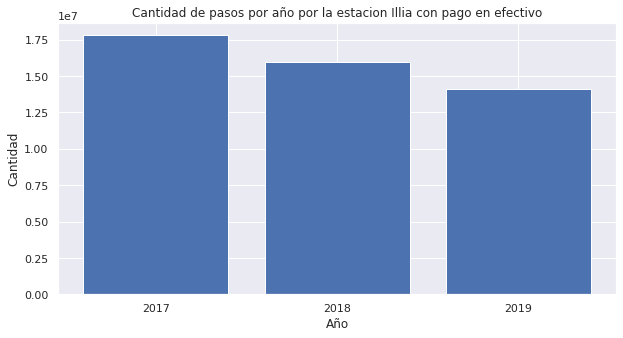

In [36]:
year = data_formatted.groupby(['anio']).sum()['cantidad_pasos']
year=pd.DataFrame(year)
year.reset_index(inplace=True)
year.anio = year.anio.astype('category')
plt.figure(figsize=(10,5))
plt.bar(x= year.anio,height=year.cantidad_pasos)
plt.title('Cantidad de pasos por año por la estacion Illia con pago en efectivo')
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.xticks(np.arange(2017,2020,1))
plt.show()

Se observa una disminución del tráfico a través de la autopista illia del año 2017 al 2019.

#### ¿Varía la cantidad de tráfico en la autopista illia con los meses del año?

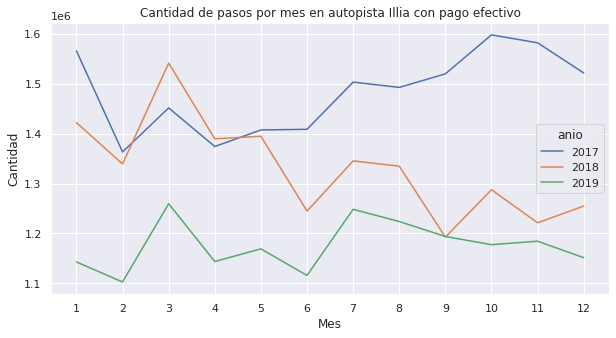

In [37]:
month = data_formatted.groupby(['mes','anio']).sum()['cantidad_pasos']
month=pd.DataFrame(month)
month.reset_index(inplace=True)
month.anio = month.anio.astype('category')
plt.figure(figsize=(10,5))
sns.lineplot(x= month.mes,y=month.cantidad_pasos, hue=month.anio,data=month)
plt.title('Cantidad de pasos por mes en autopista Illia con pago efectivo')
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.xticks(np.arange(1,13,1))
plt.show()

Como se había visto más arriba, la cantidad de tráfico viene bajando del 2017 al 2019. En cuanto a los meses, para 2018 y 2019 se observan picos en el mes de Marzo, y después el tráfico tiende a caer en los siguientes meses del año. Sin embargo, esto no fue así en 2017, donde el pico de tráfico se dio en el mes de Octubre.

#### ¿Cómo afecta el día de la semana al tráfico por la autopista?

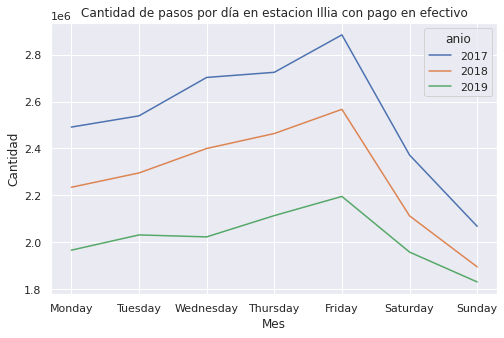

In [38]:
day = data_formatted.groupby(['dia_semana','anio']).sum()['cantidad_pasos']
day = pd.DataFrame(day)
day.reset_index(inplace=True)
# Para ordenar los días empezando por Lunes y terminando el Domingo
sorter = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
sorter_index = dict(zip(sorter,range(len(sorter))))
day['number'] = day.dia_semana
day['number'] = day['number'].map(sorter_index)
day=day.sort_values('number',ascending=True)
day.anio = day.anio.astype('category')
plt.figure(figsize=(8,5))
sns.lineplot(x= day.dia_semana,y=day.cantidad_pasos,hue=day.anio,sort=False)
plt.title('Cantidad de pasos por día en estacion Illia con pago en efectivo')
plt.xlabel("Mes")
plt.ylabel("Cantidad")
plt.show()

Tal como esperábamos, a partir del Viernes, que empieza el finde semana, el tráfico disminuye en los 3 años considerados. Además, se observa que el tráfico crece de Lunes a Viernes, donde alcanza un pico, y vuelve a caer hasta el Domingo. Esta tendencia se observa en 2017, 2018 y 2019.

### Valores faltantes

In [39]:
diario.reset_index(inplace=True)
diario.isna().sum()

fecha             0
cantidad_pasos    0
dtype: int64

Todas las fechas tiene una cantidad de pasos.

Ahora voy a averiguar si están faltando fechas en el dataset

In [40]:
print(diario)
print(diario.columns)
print(diario.shape)
print(diario.fecha)

          fecha  cantidad_pasos
0    2017-01-01           31183
1    2017-01-02           51568
2    2017-01-03           51093
3    2017-01-04           53332
4    2017-01-05           56486
...         ...             ...
1090 2019-12-27           40182
1091 2019-12-28           30681
1092 2019-12-29           26259
1093 2019-12-30           34523
1094 2019-12-31           21447

[1095 rows x 2 columns]
Index(['fecha', 'cantidad_pasos'], dtype='object')
(1095, 2)
0      2017-01-01
1      2017-01-02
2      2017-01-03
3      2017-01-04
4      2017-01-05
          ...    
1090   2019-12-27
1091   2019-12-28
1092   2019-12-29
1093   2019-12-30
1094   2019-12-31
Name: fecha, Length: 1095, dtype: datetime64[ns]


In [41]:
date_check = diario.fecha.diff()
date_check.value_counts()

1 days    1094
Name: fecha, dtype: int64

Todos los días están presentes en la serie de tiempo.

In [42]:
diario.describe()

,cantidad_pasos
count,1095.000000
mean,43712.859361
std,8192.736927
min,0.000000
25%,39061.500000
50%,43761.000000
75%,49498.000000
max,63127.000000


In [43]:
diario.cantidad_pasos.value_counts()

0        4
42370    2
35383    2
45216    2
37172    2
        ..
52553    1
46408    1
44357    1
52548    1
57344    1
Name: cantidad_pasos, Length: 1071, dtype: int64

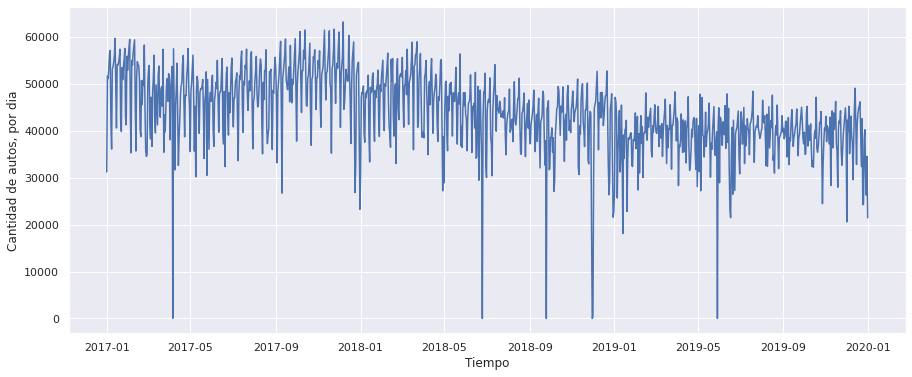

In [44]:
plt.figure(figsize = (15,6))
plt.plot(diario.fecha, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Observando lo anterior, se puede concluir que los valores cercanos a 0 son outliers, y por lo tanto los voy a eliminar. A Partir de la observación del gráfico, primero voy a eliminar la cantidad de pasos menores a 5000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



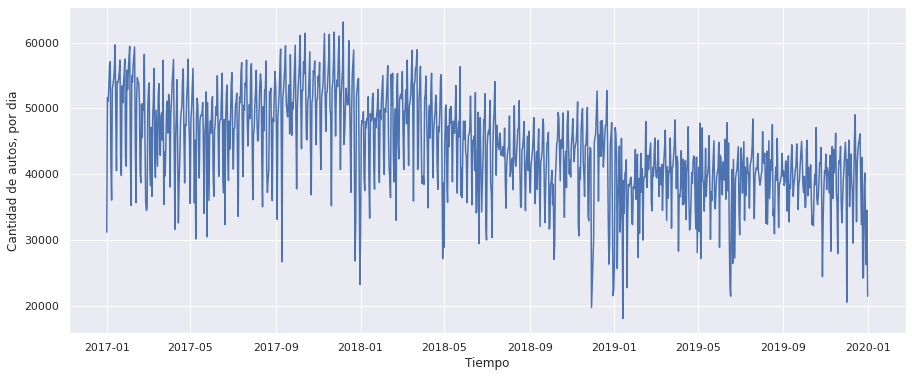

In [45]:
diario.cantidad_pasos[diario.cantidad_pasos<5000] =np.nan
diario=diario.interpolate(method='linear')
plt.figure(figsize = (15,6))
plt.plot(diario.fecha, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

Sin embargo, considero que todavía pueden haber outliers dentro de la series, que se podrían eliminar. Por eso como criterio voy a calcular la media movil de la serie, y tomar una franja de +- 2 desvíos estándar. Todos los valores que estén más allá de estos límites los considero outliers.

In [46]:
ventana = int(365/12)
monthly_rolling_mean = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()
monthly_rolling_mean

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1090   NaN
1091   NaN
1092   NaN
1093   NaN
1094   NaN
Name: cantidad_pasos, Length: 1095, dtype: float64

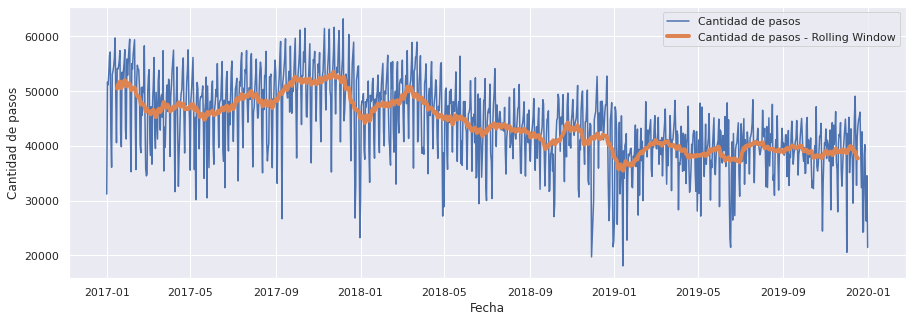

In [47]:
plt.figure(figsize = (15,5))
plt.plot(diario.fecha, diario.cantidad_pasos, label = 'Cantidad de pasos')
plt.plot(diario.fecha,monthly_rolling_mean, lw = 4, label = 'Cantidad de pasos - Rolling Window')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.legend()
plt.show()

Text(0.5, 0, 'Fecha')

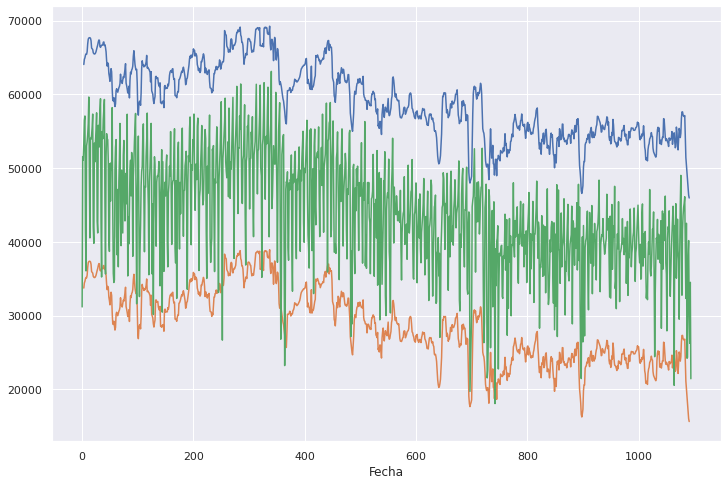

In [48]:
ventana = int(7) # Ventana semanal
weekly_rolling_mean = diario.cantidad_pasos.rolling(window=ventana, center = True).mean()
superior = weekly_rolling_mean + 2*diario.cantidad_pasos.std()
inferior = weekly_rolling_mean - 2*diario.cantidad_pasos.std()
plt.figure(figsize=(12,8))
plt.plot(superior, label = 'Banda superior')
plt.plot(inferior, label='Banda inferior')
plt.plot(diario.index,diario.cantidad_pasos, label='Cantidad de pasos')
plt.xlabel('Fecha')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 0, 'Fecha')

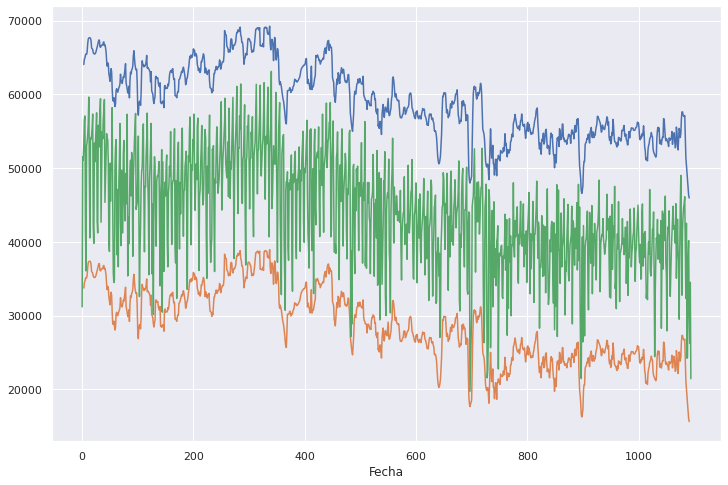

In [49]:
for i in range(1095):
    if (diario.cantidad_pasos[i] > superior[i]) | (diario.cantidad_pasos[i]<inferior[i]):
        diario.cantidad_pasos[i]= np.nan
diario=diario.interpolate(method='linear')
plt.figure(figsize=(12,8))
plt.plot(superior, label = 'Banda superior')
plt.plot(inferior, label='Banda inferior')
plt.plot(diario.index,diario.cantidad_pasos, label='Cantidad de pasos')
plt.xlabel('Fecha')

In [50]:
# chequeo que no hayan valores faltantes
diario.isna().sum()

fecha             0
cantidad_pasos    0
dtype: int64

In [51]:
# Chequeo las diferencias en las fechas
date_check = diario.fecha.diff()
date_check.value_counts()

1 days    1094
Name: fecha, dtype: int64

No falta ningún día.

### Componentes de la serie

Voy a descomponer la serie en sus componentes tendencial, estacional y los residuos.

In [52]:
diario.set_index(keys=diario.fecha,inplace=True)
diario=diario.cantidad_pasos
result = seasonal_decompose(diario, model='additive')


In [53]:
result.trend

fecha
2017-01-01             NaN
2017-01-02             NaN
2017-01-03             NaN
2017-01-04    48904.285714
2017-01-05    49601.714286
                  ...     
2019-12-27    31197.428571
2019-12-28    30801.285714
2019-12-29             NaN
2019-12-30             NaN
2019-12-31             NaN
Name: cantidad_pasos, Length: 1095, dtype: float64

In [54]:
result.seasonal

fecha
2017-01-01   -6138.141005
2017-01-02   -1155.022572
2017-01-03     -11.370037
2017-01-04    1810.615890
2017-01-05    3044.525688
                 ...     
2019-12-27    5065.153893
2019-12-28   -2615.761857
2019-12-29   -6138.141005
2019-12-30   -1155.022572
2019-12-31     -11.370037
Name: cantidad_pasos, Length: 1095, dtype: float64

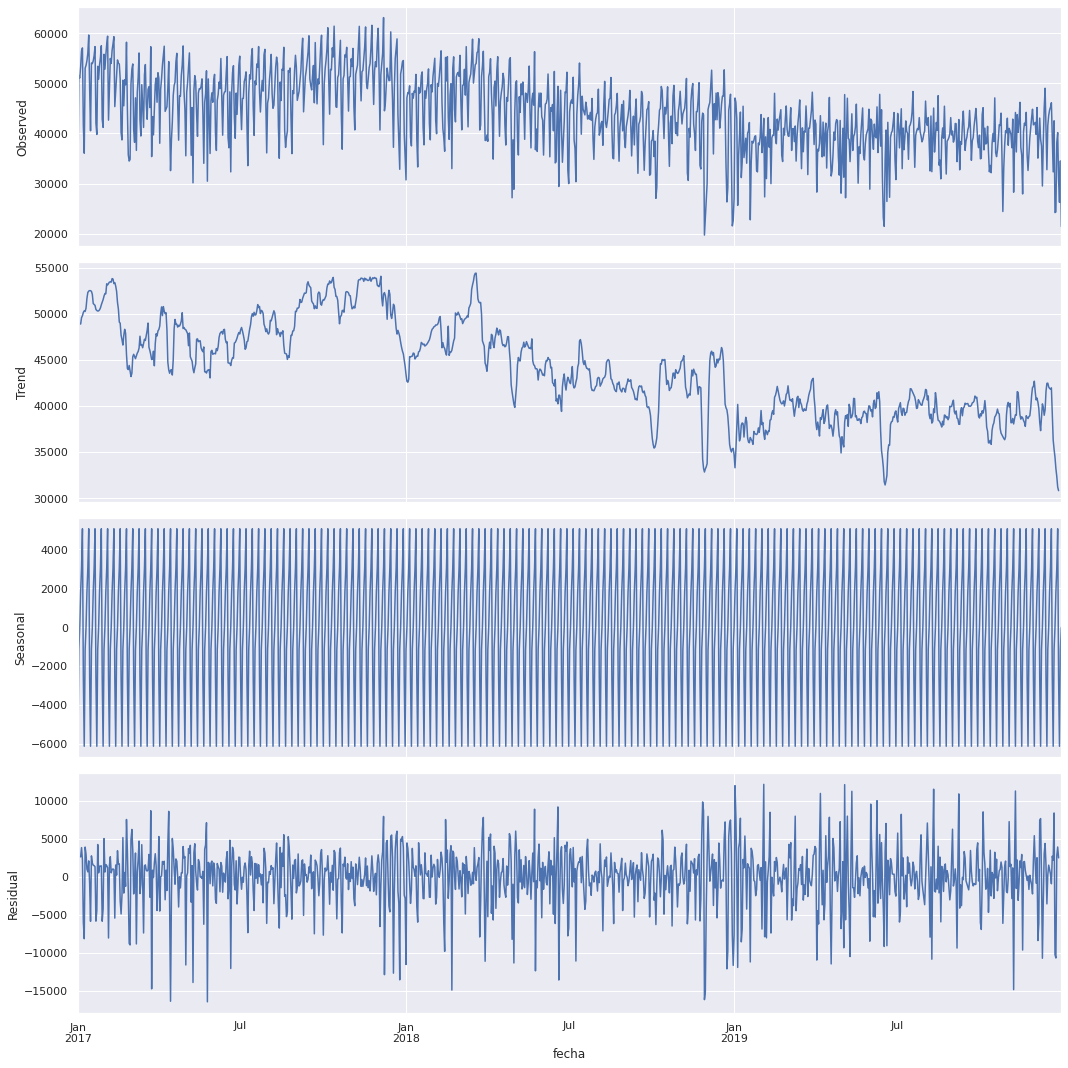

In [55]:
plt.rcParams['figure.figsize'] = [15,15]
result.plot()
plt.show()

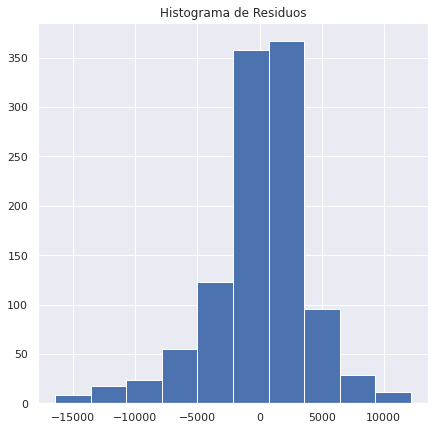

In [56]:
plt.figure(figsize=(7,7))
plt.hist(result.resid)
plt.title("Histograma de Residuos")
plt.show()

### Autocorrelacion

Voy a calcular la autocorrelación de la serie, para entender cuántos valores hacia atrás en el tiempo son significativos para predecir.

In [57]:
nlags =  365*3
autocorr = acf(diario, nlags = nlags)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



In [58]:
print(autocorr.shape)
print(diario.shape)

(1095,)
(1095,)


Text(0.5, 0, 'lag')

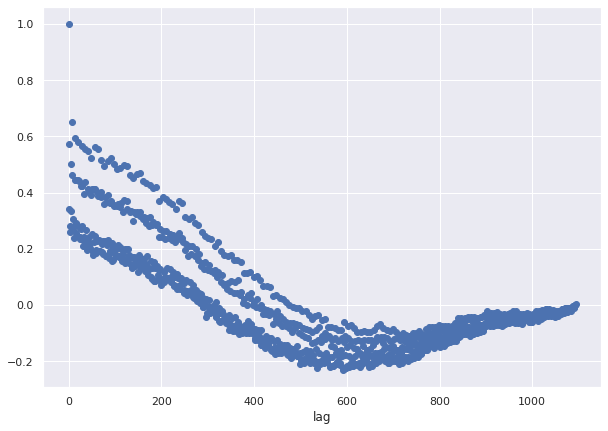

In [59]:
plt.figure(figsize = (10,7))
plt.scatter(np.arange(nlags), autocorr)
plt.xlabel('lag')

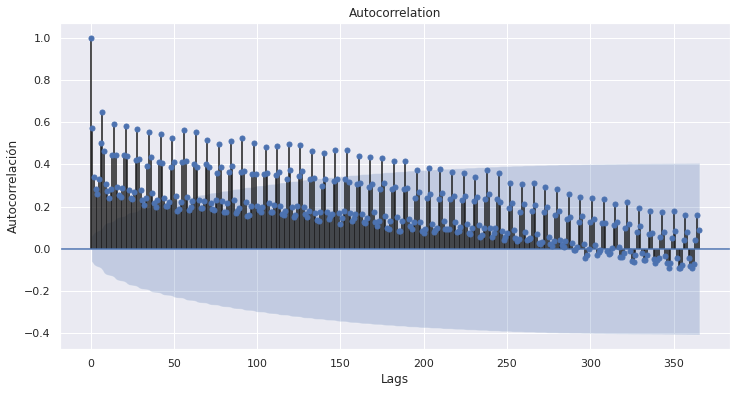

In [60]:
fig=plot_acf(diario, lags = 366-1)
fig.set_size_inches(12, 6)
plt.ylabel('Autocorrelación')
plt.xlabel('Lags')
plt.show()
# Los intervalos de confianza se grafican como un cono. Las correlaciones por fuera de este cono, son estadísticamente significativas.

Observando el gráfico, se puede concluir que hasta aproximadamente 200 valores hacia atrás tienen una correlación significativa. Por lo tanto para predecir voy a usar un loock back de 200.

In [61]:
serie = diario
serie.head()

fecha
2017-01-01    31183.0
2017-01-02    51568.0
2017-01-03    51093.0
2017-01-04    53332.0
2017-01-05    56486.0
Name: cantidad_pasos, dtype: float64

In [62]:
serie.describe()

count     1095.000000
mean     44074.447032
std       7429.521366
min      19728.000000
25%      39200.000000
50%      43850.000000
75%      49571.500000
max      63127.000000
Name: cantidad_pasos, dtype: float64

## Prophet

La primer librería que voy a probar es Prophet. Esta es una librería open-source desarrollada por Facebook para predecir series de tiempo. Como inpunt, esta librería recibe un dataframe con las columnas "ds" con formato de fecha (en nuestro caso YYYY-MM-DD) y una columna "y" (numérica) con los valores que buscamos predecir.

In [ ]:
# Transformamos nuestra serie en un dataframe:
df=serie.to_frame()
df.reset_index(inplace=True)
df

,fecha,cantidad_pasos
0,2017-01-01,31183.0
1,2017-01-02,51568.0
2,2017-01-03,51093.0
3,2017-01-04,53332.0
4,2017-01-05,56486.0
...,...,...
1090,2019-12-27,40182.0
1091,2019-12-28,30681.0
1092,2019-12-29,26259.0
1093,2019-12-30,34523.0


In [ ]:
# Utilizamos los nombres de columnas especificados en la documentación:
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])
df

,ds,y
0,2017-01-01,31183.0
1,2017-01-02,51568.0
2,2017-01-03,51093.0
3,2017-01-04,53332.0
4,2017-01-05,56486.0
...,...,...
1090,2019-12-27,40182.0
1091,2019-12-28,30681.0
1092,2019-12-29,26259.0
1093,2019-12-30,34523.0


Primero, voy a utilizar todo el dataset para entrenar el modelo, y luego lo voy a utilizar para predecir los valores para el año 2019 y el año 2020.

In [ ]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# predicción de valores para el año 2019
future = list()
inicio = pd.datetime(2019,1,1)
future = [inicio + datetime.timedelta(days=d) for d in range(365)] 
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [ ]:
future

,ds
0,2019-01-01
1,2019-01-02
2,2019-01-03
3,2019-01-04
4,2019-01-05
...,...
360,2019-12-27
361,2019-12-28
362,2019-12-29
363,2019-12-30


          ds          yhat    yhat_lower    yhat_upper
0 2019-01-01  37187.893024  31642.018934  43036.976337
1 2019-01-02  38932.291540  32680.307725  44638.545441
2 2019-01-03  40058.352580  33773.765109  45920.637512
3 2019-01-04  41995.451070  36093.967415  48162.347796
4 2019-01-05  34255.366121  28531.731031  40564.926587


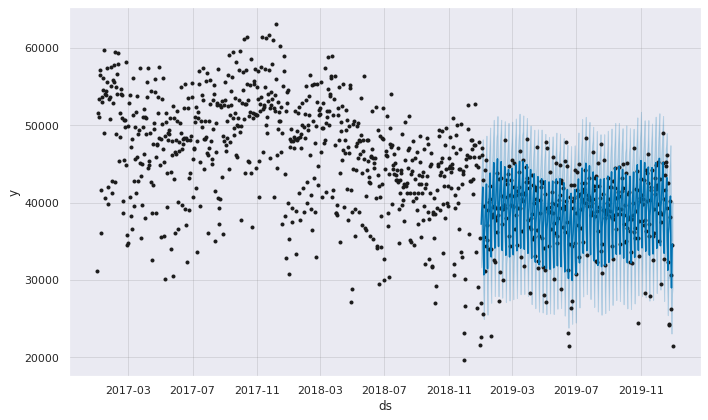

In [ ]:
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



          ds          yhat    yhat_lower    yhat_upper
0 2020-01-01  36352.369554  30527.087779  42302.609760
1 2020-01-02  37437.807099  31194.968260  43520.489369
2 2020-01-03  39333.493471  33081.726224  45582.943883
3 2020-01-04  31551.899131  26130.699101  37075.353444
4 2020-01-05  27917.173450  22396.735706  34075.296944


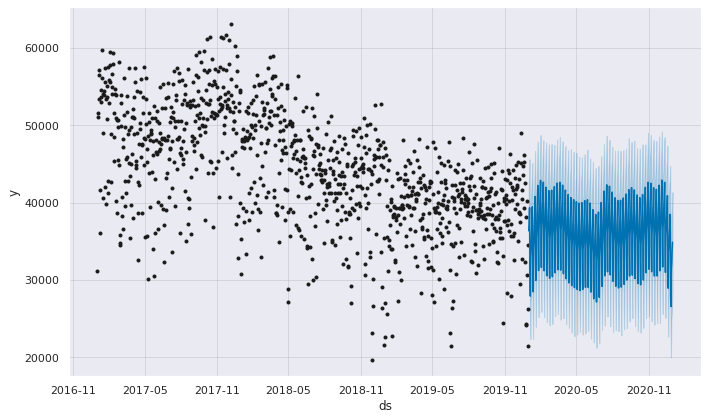

In [ ]:
# prediccion 2020
future = list()
inicio = pd.datetime(2020,1,1)
future = [inicio + datetime.timedelta(days=d) for d in range(366)] 
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast)
plt.show()

In [ ]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

            ds          yhat    yhat_lower    yhat_upper
0   2020-01-01  36352.369554  30527.087779  42302.609760
1   2020-01-02  37437.807099  31194.968260  43520.489369
2   2020-01-03  39333.493471  33081.726224  45582.943883
3   2020-01-04  31551.899131  26130.699101  37075.353444
4   2020-01-05  27917.173450  22396.735706  34075.296944
..         ...           ...           ...           ...
361 2020-12-27  26569.137947  19989.394473  32960.208354
362 2020-12-28  31385.279256  24841.039495  38058.713675
363 2020-12-29  32169.022338  25644.634571  38443.826165
364 2020-12-30  33835.228688  27076.068961  40074.894752
365 2020-12-31  34879.299976  28734.305095  41342.844053

[366 rows x 4 columns]


Hasta ahora el modelo entrenó con todos los datos, y con este modelo predecimos los valores de 2019 (que eran datos con los que el modelo había entrenado) y los valores para el año 2020, que no se encuentran dentro del dataset, y por lo tanto eran desconocidos para el modelo.

Para poder evaluar el desempeño del modelo, voy a usar el mismo criterio que utilicé en el tercer proyecto. Esto significa que voy a utilizar un loock back igual a 200, con el 80% de datos de enternamiento, y el último 20% (219 valores instancias) compuesto de datos de testeo para evaluar los modelos. Esto permite comparar los resultados de los modelos con los del proyecto anterior.

In [ ]:
# El conjunto de datos de entrenamiento está conformado por el primer 80% de instancias.
train = df.drop(df.index[-219:])
train.tail()

,ds,y
871,2019-05-22,39861.0
872,2019-05-23,42597.0
873,2019-05-24,45091.0
874,2019-05-25,35626.0
875,2019-05-26,34712.0


Los datos de entrenamiento van desde el 2017-01-01 al 2019-05-26.
Los datos de testeo van desde el 2019-05-27 al 2019-12-31

In [ ]:
# Entreno el modelo usando los datos de entenamiento
model = Prophet()
model.fit(train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



          ds          yhat    yhat_lower    yhat_upper
0 2017-01-01  40262.588165  34751.417159  46077.373249
1 2017-01-02  46104.713254  40184.303963  52329.568796
2 2017-01-03  47057.303818  41687.533842  53018.333270
3 2017-01-04  48924.146896  43188.949157  54369.912374
4 2017-01-05  50246.349664  44110.800906  56191.813231


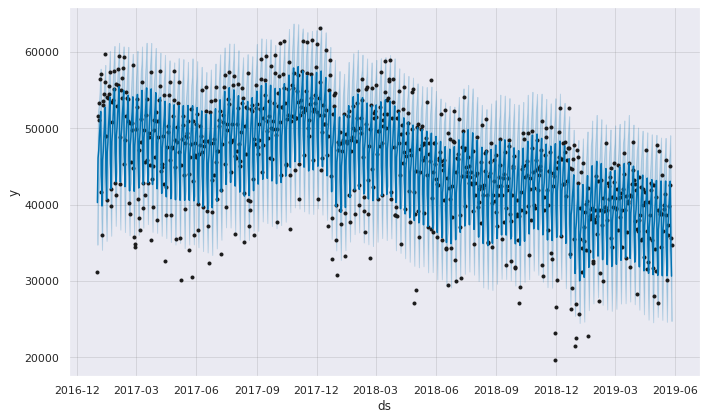

In [ ]:
# Con el modelo ya enternado, lo uso para predecir en el conjunto de datos de entrenamiento, para luego poder calcular el RMSE en este dataset.
x_train = list()
inicio = pd.datetime(2017,1,1)
x_train = [inicio + datetime.timedelta(days=d) for d in range(int(365*3*0.8))] 
x_train = pd.DataFrame(x_train)
x_train.columns = ['ds']
x_train['ds']= pd.to_datetime(x_train['ds'])
forecast_train = model.predict(x_train)
print(forecast_train[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast_train)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



          ds          yhat    yhat_lower    yhat_upper
0 2019-05-27  36612.805287  30649.265773  42282.006218
1 2019-05-28  37667.392275  32442.190676  43672.833567
2 2019-05-29  39601.193654  33625.453310  45626.468321
3 2019-05-30  40954.525094  35294.561575  46501.674576
4 2019-05-31  42887.901276  36954.040010  48935.414829


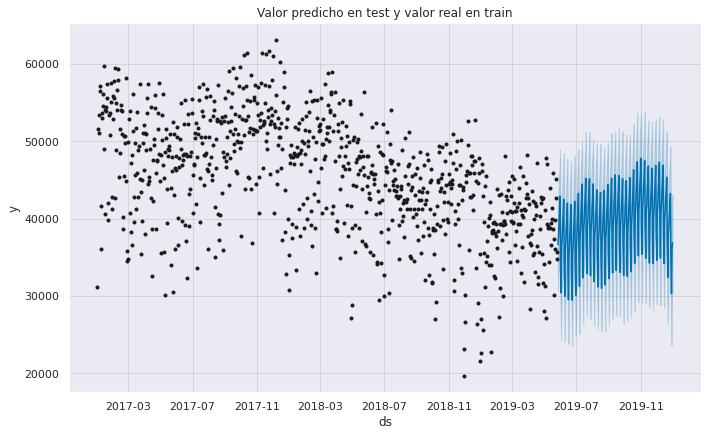

In [ ]:
# Ahora uso el modelo para predecir con los datos de testeo, para luego evaluar el desempeño del mismo.
x_test = list()
inicio = pd.datetime(2019,5,27)
x_test = [inicio + datetime.timedelta(days=d) for d in range(219)] 
x_test = pd.DataFrame(x_test)
x_test.columns = ['ds']
x_test['ds']= pd.to_datetime(x_test['ds'])
forecast_test = model.predict(x_test)
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
model.plot(forecast_test)
plt.title('Valor predicho en test y valor real en train')
plt.show()

In [ ]:
x_test.tail

<bound method NDFrame.tail of             ds
0   2019-05-27
1   2019-05-28
2   2019-05-29
3   2019-05-30
4   2019-05-31
..         ...
214 2019-12-27
215 2019-12-28
216 2019-12-29
217 2019-12-30
218 2019-12-31

[219 rows x 1 columns]>

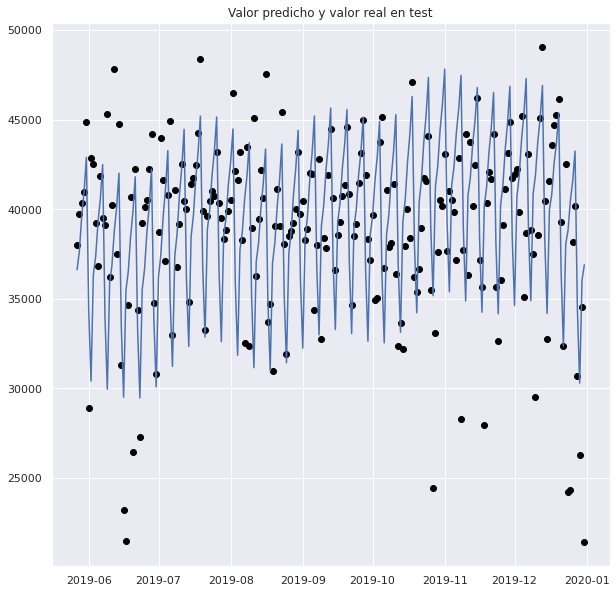

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(forecast_test['ds'],forecast_test['yhat'],label='Predicho')
plt.scatter(df['ds'][-219:],df['y'][-219:],c='black',label='Valores reales')
plt.title('Valor predicho y valor real en test')
plt.show()

En este gráfico podemos comparar los valores reales del conjunto de testeo, con los que predice nuestro modelo.

In [ ]:
y_train = df['y'][:-219].values
y_test = df['y'][-219:].values
y_train_pred=forecast_train['yhat']
y_test_pred=forecast_test['yhat']
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE de los datos de entrenamiento: ", rmse_train, "\nRMSE de los datos de testeo :", rmse_test)

RMSE de los datos de entrenamiento:  4565.888264508234 
RMSE de los datos de testeo : 5000.391115041782


Como conclusión, la librería Prophet es sencilla de utilizar, y los resultados obtenidos superan a casi todos los modelos entrenados en el tercer proyecto. Sin embargo, el RMSE obtenido es un 5,9% superior al error alcanzado con el modelo random forest. 

Por otro lado, una ventaja que tiene esta librería, es que el modelo random forest, para poder alcanzar esos resultados superiores, necesitó una optimización de hiperparámetros utilizando primero un random search, y luego un grid search para mejorar aún más los resultados. Estas optimizaciones requieren mucho tiempo, mientras que el modelo Prophet, si bien tuvo peores resultados, fue mucho más rapido a la hora de entrenar.

## Redes neuronales LSTM

Ahora se utilizarán redes neuronales LSTM. Estas son redes neuronales recurrentes muy utilizadas con series de tiempo. Se van a entrenar distintos modelos y se calculará su RMSE en los datos de testeo.

In [63]:
df=serie.to_frame()
df

,cantidad_pasos
fecha,
2017-01-01,31183.0
2017-01-02,51568.0
2017-01-03,51093.0
2017-01-04,53332.0
2017-01-05,56486.0
...,...
2019-12-27,40182.0
2019-12-28,30681.0
2019-12-29,26259.0


In [64]:
df.shape

(1095, 1)

In [65]:
train, test = df[:-219], df[-219:]
print(train)
print(test)

            cantidad_pasos
fecha                     
2017-01-01         31183.0
2017-01-02         51568.0
2017-01-03         51093.0
2017-01-04         53332.0
2017-01-05         56486.0
...                    ...
2019-05-22         39861.0
2019-05-23         42597.0
2019-05-24         45091.0
2019-05-25         35626.0
2019-05-26         34712.0

[876 rows x 1 columns]
            cantidad_pasos
fecha                     
2019-05-27         37985.0
2019-05-28         39739.0
2019-05-29         40353.5
2019-05-30         40968.0
2019-05-31         44849.0
...                    ...
2019-12-27         40182.0
2019-12-28         30681.0
2019-12-29         26259.0
2019-12-30         34523.0
2019-12-31         21447.0

[219 rows x 1 columns]


Antes de comenzar a entrenar los distintos modelos, es importante escalar los datos. Para este caso se utilizará MinMaxScaler de la librería Scikit Learn, que transforma los datos en valores que se encuentran de 0 a 1.

In [66]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

Para comenzar a entrenar los modelos, se necesita preparar los datos. Para eso se utilizará TimeseriesGenerator de la librería Keras, que transforma automáticamente los datos para entrenar redes neuronales.

In [67]:
# n_input: es el loock back que usamos para definir los datos de testeo y entrenamiento.
n_input = 200
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

Se van a entrenar distintos modelos probando con distintas cantidades de neuronas y capas, y se evaluará el RMSE para cada una de ellas.
La función de activación que se utilizará es "relu" (esta función toma el valor máximo entre la variable y el 0, es decir que si la variables es negativa, la salida es 0, mientras que si es positiva, la salida es igual a la variable).

Además se va a utilizar dropout, que es una capa de exclusión en el modelo. Esto se utiliza para evitar el sobreajuste de la red neuronal

In [187]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [188]:
model.fit_generator(generator,epochs=50)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
113/113 [==============================] - 21s 161ms/step - loss: 0.1004
Epoch 2/50
113/113 [==============================] - 17s 149ms/step - loss: 0.0193
Epoch 3/50
113/113 [==============================] - 17s 148ms/step - loss: 0.0190
Epoch 4/50
113/113 [==============================] - 17s 147ms/step - loss: 0.0217
Epoch 5/50
113/113 [==============================] - 17s 148ms/step - loss: 0.0186
Epoch 6/50
113/113 [==============================] - 17s 148ms/step - loss: 0.0231
Epoch 7/50
113/113 [==============================] - 17s 149ms/step - loss: 0.0199
Epoch 8/50
113/113 [==============================] - 17s 149ms/step - loss: 0.0249
Epoch 9/50
113/113 [==============================] - 17s 152ms/step - loss: 0.0210
Epoch 10/50
113/113 [==============================] - 17s 149ms/step - loss: 0.0205
Epoch 11/50
113/113 [==============================] - 17s 151ms/step - loss: 0.0193
Epoch 12/50
113/113 [==============================] - 17s 152ms/step - lo

In [189]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(219):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [190]:
test_pred = scaler.inverse_transform(pred_list)
test_pred = pd.DataFrame(test_pred,index=df[-219:].index,columns=['Prediccion'])


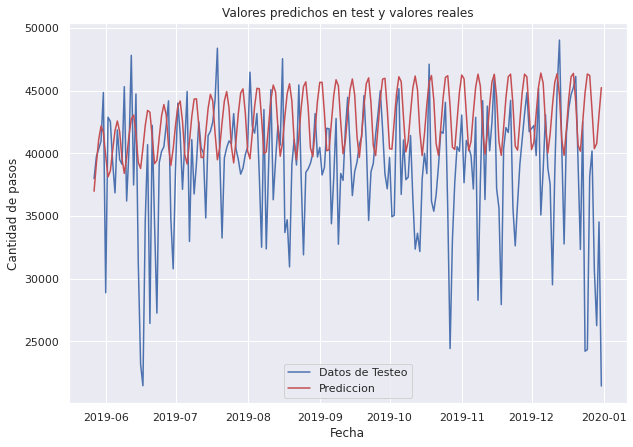

In [191]:
plt.figure(figsize=(10,7))
plt.plot(df[-219:],label='Datos de Testeo')
plt.plot(test_pred.index, test_pred.Prediccion, color='r',label='Prediccion')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.title('Valores predichos en test y valores reales')
plt.legend()
plt.show()

In [192]:
rmse_test = np.sqrt(mean_squared_error(df[-219:], test_pred))
print("RMSE de los datos de testeo : ", rmse_test)

RMSE de los datos de testeo :  6552.468693474557


In [193]:
# Pruebo con otra red
model_2 = Sequential()
model_2.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model_2.add(Dropout(0.15))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mse')

In [194]:
model_2.fit_generator(generator,epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



113/113 [==============================] - 10s 75ms/step - loss: 0.1063
Epoch 2/50
113/113 [==============================] - 9s 76ms/step - loss: 0.0225
Epoch 3/50
113/113 [==============================] - 9s 75ms/step - loss: 0.0221
Epoch 4/50
113/113 [==============================] - 9s 75ms/step - loss: 0.0216
Epoch 5/50
113/113 [==============================] - 8s 75ms/step - loss: 0.0216
Epoch 6/50
113/113 [==============================] - 8s 74ms/step - loss: 0.0189
Epoch 7/50
113/113 [==============================] - 8s 74ms/step - loss: 0.0198
Epoch 8/50
113/113 [==============================] - 8s 74ms/step - loss: 0.0211
Epoch 9/50
113/113 [==============================] - 8s 73ms/step - loss: 0.0202
Epoch 10/50
113/113 [==============================] - 8s 73ms/step - loss: 0.0217
Epoch 11/50
113/113 [==============================] - 8s 74ms/step - loss: 0.0198
Epoch 12/50
113/113 [==============================] - 8s 75ms/step - loss: 0.0214
Epoch 13/50
113/113 [==

In [195]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(219):   
    pred_list.append(model_2.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [196]:
test_pred = scaler.inverse_transform(pred_list)
test_pred = pd.DataFrame(test_pred,index=df[-219:].index,columns=['Prediccion'])

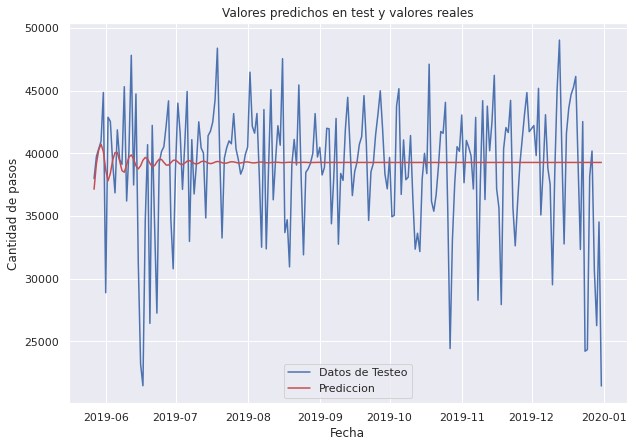

In [197]:
plt.figure(figsize=(10,7))
plt.plot(df[-219:],label='Datos de Testeo')
plt.plot(test_pred.index, test_pred.Prediccion, color='r',label='Prediccion')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.title('Valores predichos en test y valores reales')
plt.legend()
plt.show()

In [198]:
rmse_test = np.sqrt(mean_squared_error(df[-219:], test_pred))
print("RMSE de los datos de testeo : ", rmse_test)

RMSE de los datos de testeo :  4984.536026609889


In [199]:
# Pruebo con otro modelo
model_3 = Sequential()
model_3.add(LSTM(250, activation='relu', input_shape=(n_input, n_features)))
model_3.add(Dropout(0.15))
model_3.add(Dense(1))
model_3.compile(optimizer='adam', loss='mse')

In [200]:
model_3.fit_generator(generator,epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



113/113 [==============================] - 31s 256ms/step - loss: 0.0742
Epoch 2/50
113/113 [==============================] - 29s 257ms/step - loss: 0.0204
Epoch 3/50
113/113 [==============================] - 29s 253ms/step - loss: 0.0173
Epoch 4/50
113/113 [==============================] - 28s 251ms/step - loss: 0.0214
Epoch 5/50
113/113 [==============================] - 27s 238ms/step - loss: 0.0213
Epoch 6/50
113/113 [==============================] - 27s 238ms/step - loss: 0.0209
Epoch 7/50
113/113 [==============================] - 24s 216ms/step - loss: 0.0195
Epoch 8/50
113/113 [==============================] - 24s 212ms/step - loss: 0.0207
Epoch 9/50
113/113 [==============================] - 26s 228ms/step - loss: 0.0215
Epoch 10/50
113/113 [==============================] - 27s 237ms/step - loss: 0.0217
Epoch 11/50
113/113 [==============================] - 26s 229ms/step - loss: 0.0228
Epoch 12/50
113/113 [==============================] - 25s 224ms/step - loss: 0.0192


In [201]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(219):   
    pred_list.append(model_3.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [202]:
test_pred = scaler.inverse_transform(pred_list)
test_pred = pd.DataFrame(test_pred,index=df[-219:].index,columns=['Prediccion'])


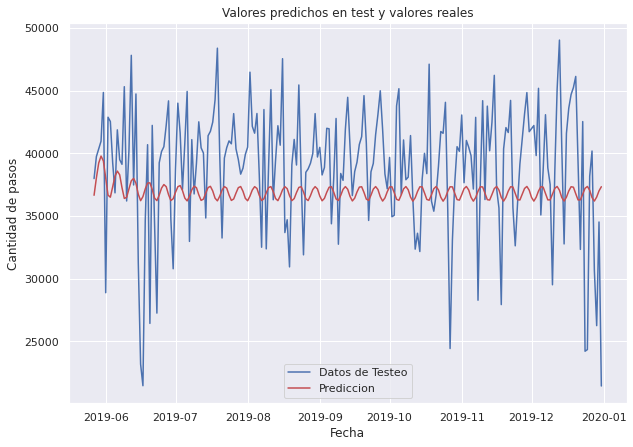

In [203]:
plt.figure(figsize=(10,7))
plt.plot(df[-219:],label='Datos de Testeo')
plt.plot(test_pred.index, test_pred.Prediccion, color='r',label='Prediccion')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.title('Valores predichos en test y valores reales')
plt.legend()
plt.show()

In [204]:
rmse_test = np.sqrt(mean_squared_error(df[-219:], test_pred))
print("RMSE de los datos de testeo : ", rmse_test)

RMSE de los datos de testeo :  5370.568405845968


In [205]:
model_4 = Sequential()
model_4.add(LSTM(50, activation='relu', input_shape=(n_input, n_features),return_sequences=True))
model_4.add(Dropout(0.15))
model_4.add(LSTM(50, activation='relu',return_sequences=True))
model_4.add(Dropout(0.15))
model_4.add(LSTM(50, activation='relu'))
model_4.add(Dropout(0.15))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mse')

In [206]:
model_4.fit_generator(generator,epochs=8)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/8
113/113 [==============================] - 21s 150ms/step - loss: 0.1326
Epoch 2/8
113/113 [==============================] - 17s 149ms/step - loss: 0.0248
Epoch 3/8
113/113 [==============================] - 17s 147ms/step - loss: 0.0250
Epoch 4/8
113/113 [==============================] - 17s 147ms/step - loss: 0.0316
Epoch 5/8
113/113 [==============================] - 17s 146ms/step - loss: 0.0254
Epoch 6/8
113/113 [==============================] - 17s 148ms/step - loss: 0.0236
Epoch 7/8
113/113 [==============================] - 17s 147ms/step - loss: 0.0262
Epoch 8/8
113/113 [==============================] - 17s 148ms/step - loss: 0.0223


In [207]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(219):   
    pred_list.append(model_4.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [208]:
test_pred = scaler.inverse_transform(pred_list)
test_pred = pd.DataFrame(test_pred,index=df[-219:].index,columns=['Prediccion'])

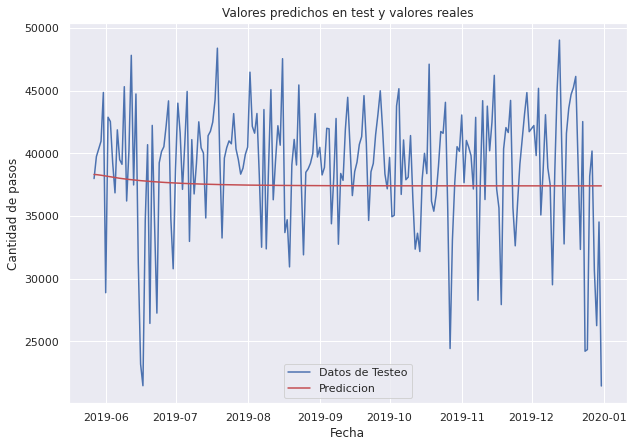

In [209]:
plt.figure(figsize=(10,7))
plt.plot(df[-219:],label='Datos de Testeo')
plt.plot(test_pred.index, test_pred.Prediccion, color='r',label='Prediccion')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.title('Valores predichos en test y valores reales')
plt.legend()
plt.show()

In [210]:
rmse_test = np.sqrt(mean_squared_error(df[-219:], test_pred))
print("RMSE de los datos de testeo : ", rmse_test)

RMSE de los datos de testeo :  5174.393729400503


In [217]:
model_5 = Sequential()
model_5.add(LSTM(50, activation='relu', input_shape=(n_input, n_features),return_sequences=True))
model_5.add(Dropout(0.15))
model_5.add(LSTM(50, activation='relu'))
model_5.add(Dropout(0.15))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mse')

In [218]:
model_5.fit_generator(generator,epochs=8)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/8
113/113 [==============================] - 15s 100ms/step - loss: 0.1236
Epoch 2/8
113/113 [==============================] - 11s 100ms/step - loss: 0.0212
Epoch 3/8
113/113 [==============================] - 11s 100ms/step - loss: 0.0222
Epoch 4/8
113/113 [==============================] - 11s 100ms/step - loss: 0.0205
Epoch 5/8
113/113 [==============================] - 11s 99ms/step - loss: 0.0257
Epoch 6/8
113/113 [==============================] - 11s 99ms/step - loss: 0.0210
Epoch 7/8
113/113 [==============================] - 11s 101ms/step - loss: 0.0195
Epoch 8/8
113/113 [==============================] - 11s 100ms/step - loss: 0.0233


In [219]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(219):   
    pred_list.append(model_5.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [220]:
test_pred = scaler.inverse_transform(pred_list)
test_pred = pd.DataFrame(test_pred,index=df[-219:].index,columns=['Prediccion'])

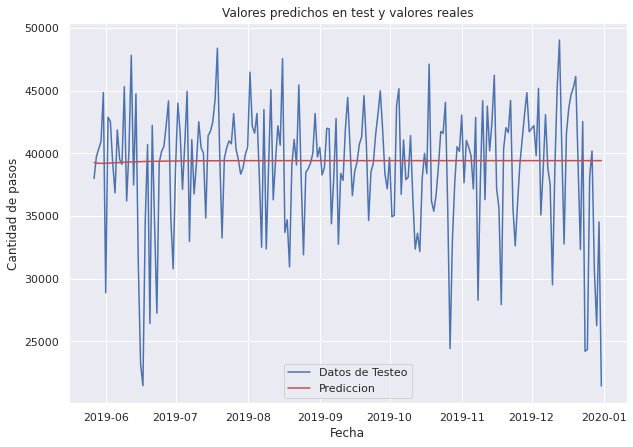

In [221]:
plt.figure(figsize=(10,7))
plt.plot(df[-219:],label='Datos de Testeo')
plt.plot(test_pred.index, test_pred.Prediccion, color='r',label='Prediccion')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.title('Valores predichos en test y valores reales')
plt.legend()
plt.show()

In [222]:
rmse_test = np.sqrt(mean_squared_error(df[-219:], test_pred))
print("RMSE de los datos de testeo : ", rmse_test)

RMSE de los datos de testeo :  4997.219074233742


In [68]:
model_6 = Sequential()
model_6.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model_6.add(Dropout(0.15))
model_6.add(Dense(1))
model_6.compile(optimizer='adam', loss='mse')

In [78]:
model_6.fit_generator(generator,epochs=50)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/50
113/113 [==============================] - 14s 124ms/step - loss: 0.0158
Epoch 2/50
113/113 [==============================] - 14s 121ms/step - loss: 0.0162
Epoch 3/50
113/113 [==============================] - 14s 121ms/step - loss: 0.0159
Epoch 4/50
113/113 [==============================] - 14s 121ms/step - loss: 0.0165
Epoch 5/50
113/113 [==============================] - 14s 120ms/step - loss: 0.0160
Epoch 6/50
113/113 [==============================] - 14s 123ms/step - loss: 0.0159
Epoch 7/50
113/113 [==============================] - 14s 121ms/step - loss: 0.0161
Epoch 8/50
113/113 [==============================] - 14s 123ms/step - loss: 0.0154
Epoch 9/50
113/113 [==============================] - 14s 121ms/step - loss: 0.0164
Epoch 10/50
113/113 [==============================] - 14s 124ms/step - loss: 0.0151
Epoch 11/50
113/113 [==============================] - 14s 121ms/step - loss: 0.0154
Epoch 12/50
113/113 [==============================] - 14s 125ms/step - lo

In [79]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(219):   
    pred_list.append(model_6.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [80]:
test_pred = scaler.inverse_transform(pred_list)
test_pred = pd.DataFrame(test_pred,index=df[-219:].index,columns=['Prediccion'])

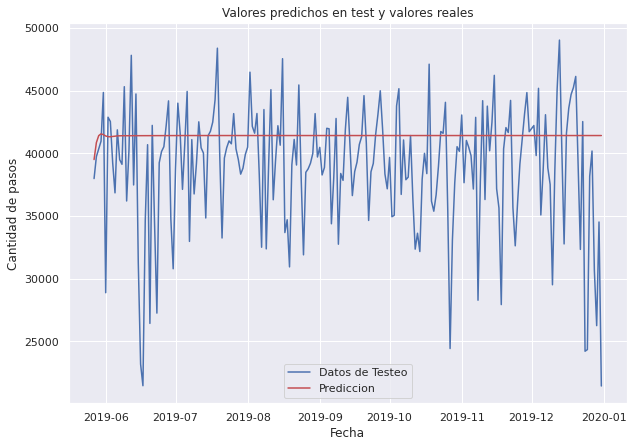

In [81]:
plt.figure(figsize=(10,7))
plt.plot(df[-219:],label='Datos de Testeo')
plt.plot(test_pred.index, test_pred.Prediccion, color='r',label='Prediccion')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pasos')
plt.title('Valores predichos en test y valores reales')
plt.legend()
plt.show()

In [82]:
rmse_test = np.sqrt(mean_squared_error(df[-219:], test_pred))
print("RMSE de los datos de testeo : ", rmse_test)

RMSE de los datos de testeo :  5563.430544790571


Resumen de los modelos entrenados y resultados obtenidos:
1. Una capa LSTM de 200 neuronas. RMSE = 6552
2. Una capa LSTM de 100 neuronas y una capa densa de 32 neuronas. RMSE = 4984
3. Una capa LSTM de 250 neuronas. RMSE = 5370
4. Tres capas LSTM de 50 neuronas. RMSE = 5174
5. Dos capas LSTM de 50 neuronas y dos capas densas de 32 neuronas. RMSE = 4997
6. Una capa LSTM de 150 neuronas. RMSE = 5563


El mejor modelo de los entrenados fue el de una capa LSTM de 100 neuronas y una capa densa de 32 neuronas, con un RMSE de 4984. Esto significa una leve mejora del 0,32% respecto al RMSE obtenido con la librería Prophet. Sin embargo, este resultado no logra superar al del Random Forest entrenado en el proyecto anterior.

## Conclusiones

Para concluir, en este proyecto se entrenaron modelos de machine learning adicionales a los que ya se habían utilizado en el proyecto anterior. Sumado a esto, la realización de este proyecto me permitió profundizar en el conocimiento de redes neuronales, y al mismo tiempo aprendí a utilizar la librería Prophet para predecir series de tiempo.

Con respecto a la librería Prophet, esta resultó muy fácil de utilizar. A diferencia de los modelos de machine larning, donde el preprocesamiento de los datos puede ser confuso, en el caso de esta librería es muy sencillo de realizar. Lo mismo sucede a la hora de realizar predicciones sobre datos no vistos, ya que con este modelo solo necesitamos crear un dataset con las fechas que deseamos predecir.

En cuanto a las redes neuronales, se entrenaron distintos modelos, probando con diferentes cantidad de neuronas y capas. Si bien los resultados de 2 de las redes entrenadas superaron levemente a los resultados obtenidos utilizando la librería Prophet, fue más complejo el armado y entrenamiento de las redes. La red con mejor desempeño fue la que está compuesta por una capa LSTM de 100 neuronas y una capa densa de 32 neuronas. Sin embargo, el RMSE obtenido fue mayor al del modelo de Random Forest entrenado anteriormente.

Si se comparan los resultados de las redes LSTM y los de la librería Prophet, me inclinaría por este último, ya que la mejora en los resultados de las redes neuronales fueron muy bajos y su complejidad es mucho mayor.

Sin embargo, el modelo Random Forest del proyecto anterior supera estos resultados en un valor cercano al 6%, por lo tanto seguiría utilizando este modelo para predecir el tráfico en la autopista Illia.



